<a href="https://colab.research.google.com/github/garthajon/QuantFinanceIntro/blob/main/ZSCORE_GARCH_PREDICTION_WITH_MONTE_CARLO_SIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install arch

/tmp/ipython-input-1914961619.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003028. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/tmp/ipython-input-1914961619.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_sigma = res.conditional_volatility[-1]
/tmp/ipython-input-191496161

COIN simulation done


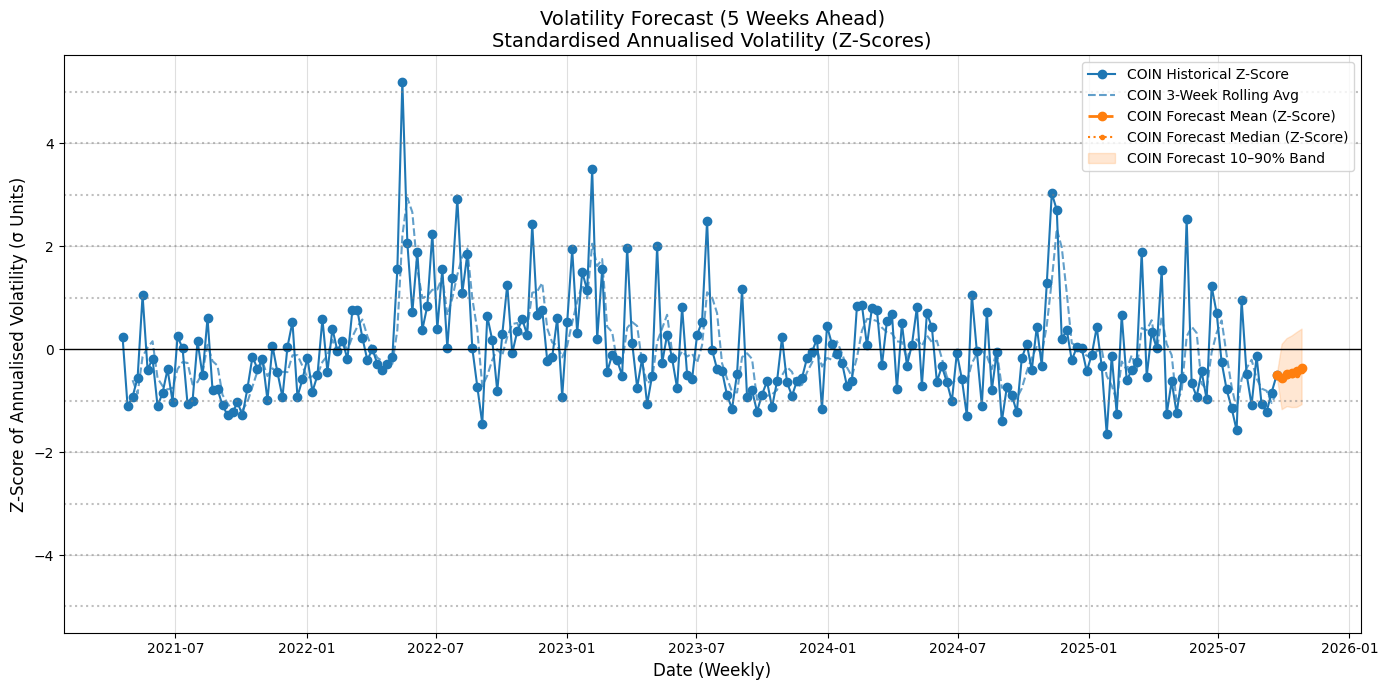

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# ---------- PARAMETERS ----------
tickers = ['COIN']
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=2)
n_weeks = 5
trading_days_per_week = 5
horizon_days = n_weeks * trading_days_per_week  # 50 trading days
n_sims = 2000
seed = 42

np.random.seed(seed)

# ---------- FETCH DATA ----------
df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
returns = df.pct_change().dropna()  # decimal returns (e.g. 0.01 = 1%)

# ---------- HISTORICAL WEEKLY REALISED VOL & Z-SCORE ----------
weekly_std = returns.resample('W').std() * np.sqrt(252)   # weekly annualised vol (decimal)
standardised = pd.DataFrame(index=weekly_std.index)
zscore_params = {}

for t in tickers:
    mu = weekly_std[t].mean()
    sigma = weekly_std[t].std(ddof=0)
    standardised[t] = (weekly_std[t] - mu) / sigma
    zscore_params[t] = (mu, sigma)

rolling_avg3 = standardised.rolling(window=3, min_periods=3).mean()

# ---------- FIT GARCH(1,1) on DECIMAL RETURNS ----------
results_store = {}
for ticker in tickers:
    am = arch_model(returns[ticker], vol='Garch', p=1, q=1, mean='Zero')
    res = am.fit(disp='off')

    omega = res.params.get('omega', res.params.iloc[0])
    alpha = res.params.get('alpha[1]', res.params.iloc[1])
    beta  = res.params.get('beta[1]', res.params.iloc[2])

    last_sigma = res.conditional_volatility[-1]
    last_resid = res.resid[-1]

    sims_weekly_z = np.zeros((n_sims, n_weeks))

    for s in range(n_sims):
        sigma = last_sigma
        eps = last_resid
        sim_returns = np.zeros(horizon_days)

        for day in range(horizon_days):
            var_next = omega + alpha * (eps ** 2) + beta * (sigma ** 2)
            var_next = max(var_next, 0.0)
            sigma_next = np.sqrt(var_next)
            z = np.random.normal()
            eps = sigma_next * z
            sigma = sigma_next
            sim_returns[day] = eps

        week_vols = []
        for w in range(n_weeks):
            start = w * trading_days_per_week
            end = start + trading_days_per_week
            ret_slice = sim_returns[start:end]
            if len(ret_slice) == 0:
                break
            week_vol = np.std(ret_slice, ddof=0) * np.sqrt(252)
            week_vols.append(week_vol)

        week_vols = np.array(week_vols)
        mu_hist, sigma_hist = zscore_params[ticker]
        week_z = (week_vols - mu_hist) / sigma_hist
        sims_weekly_z[s, :] = week_z

    results_store[ticker] = {
        'mean': np.mean(sims_weekly_z, axis=0),
        'median': np.percentile(sims_weekly_z, 50, axis=0),
        'q10': np.percentile(sims_weekly_z, 10, axis=0),
        'q90': np.percentile(sims_weekly_z, 90, axis=0),
    }

    print(f"{ticker} simulation done")

# ---------- PLOT ----------
plt.figure(figsize=(14,7))
colors = plt.cm.tab10.colors

for i, ticker in enumerate(tickers):
    # historical
    plt.plot(standardised.index, standardised[ticker], marker='o', color=colors[i], label=f'{ticker} Historical Z-Score')
    plt.plot(rolling_avg3.index, rolling_avg3[ticker], linestyle='--', color=colors[i], alpha=0.7, label=f'{ticker} 3-Week Rolling Avg')

    last_actual = standardised[ticker].iloc[-1]
    last_date = standardised.index[-1]
    forecast_index = pd.date_range(last_date, periods=n_weeks+1, freq='W')

    mean_series = np.concatenate([[last_actual], results_store[ticker]['mean']])
    median_series = np.concatenate([[last_actual], results_store[ticker]['median']])
    q10_series = np.concatenate([[last_actual], results_store[ticker]['q10']])
    q90_series = np.concatenate([[last_actual], results_store[ticker]['q90']])

    forecast_color = colors[(i+1) % len(colors)]
    plt.plot(forecast_index, mean_series, linestyle='--', color=forecast_color, linewidth=2, marker='o', label=f"{ticker} Forecast Mean (Z-Score)")
    plt.plot(forecast_index, median_series, linestyle=':', color=forecast_color, linewidth=1.5, marker='.', label=f"{ticker} Forecast Median (Z-Score)")
    plt.fill_between(forecast_index, q10_series, q90_series, color=forecast_color, alpha=0.18, label=f"{ticker} Forecast 10–90% Band")

# reference lines
plt.axhline(0, color='black', linestyle='-', linewidth=1)
for k in range(1,6):
    plt.axhline(k, color='grey', linestyle=':', alpha=0.5)
    plt.axhline(-k, color='grey', linestyle=':', alpha=0.5)

# ---------- TITLES AND LABELS ----------
plt.title(f'Volatility Forecast ({n_weeks} Weeks Ahead)\nStandardised Annualised Volatility (Z-Scores)', fontsize=14)
plt.xlabel('Date (Weekly)', fontsize=12)
plt.ylabel('Z-Score of Annualised Volatility (σ Units)', fontsize=12)

plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()
